# 3 Features Construction

## 3.1 Sharpe Ratio and the Israelsen Trick
The Sharpe Ratio is a Performance Measure wich quotes the ratio between the sample mean and volatility of asset returns.
$$
SR = \frac{\hat{\mu}}{\hat{\sigma}}
$$
Here we use the approximation of zero interest-rates in the numerator (which is nearly certain for the majority of the training and validation set)

_Israelsen_ Trick. For $\mu<0$ Sharpe Ratio calculations can induce misleading rankings. Stocks with bad trend have also high volatility and this results in a SR with a small absolute value. They can easily overrated. In order to avoid this behaviour, Israelsen introduced the modified Sharpe Ratio:

$$
ISR = \frac{\hat{\mu}}{\hat{\sigma}^{sgn(\hat\mu)}}
$$


#### Imports and Loads Needed

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plot_args = {"figsize": (21,9),            
            "legend": True
}

In [3]:
daily_rets = (
    pd.read_csv("./data/config/20220814_daily_raw_returns_merged.csv", 
    header=0, na_values="#N/A", index_col="Date", parse_dates=True)
)

#### Preliminar Checks

In [4]:
daily_rets.head()

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2011-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-06-30,0.010279,0.002528,NaN,NaN,0.004879,NaN,0.007544,NaN,0.008819,NaN,...,0.014655,0.015610,NaN,NaN,0.000181,0.008779,NaN,-0.003321,NaN,NaN
2011-07-01,0.017414,0.028373,NaN,NaN,0.022612,NaN,0.017392,NaN,0.009122,NaN,...,0.011555,0.028818,NaN,NaN,0.027335,0.029905,NaN,0.017076,NaN,NaN
2011-07-05,-0.006539,0.004905,NaN,NaN,0.017975,NaN,0.003799,NaN,0.001130,NaN,...,0.001038,-0.013071,NaN,NaN,-0.002643,-0.010294,NaN,-0.013104,NaN,NaN
2011-07-06,0.003098,-0.009152,NaN,NaN,0.006668,NaN,0.019158,NaN,0.002257,NaN,...,0.007520,0.000000,NaN,NaN,-0.007951,0.002018,NaN,-0.002490,NaN,NaN


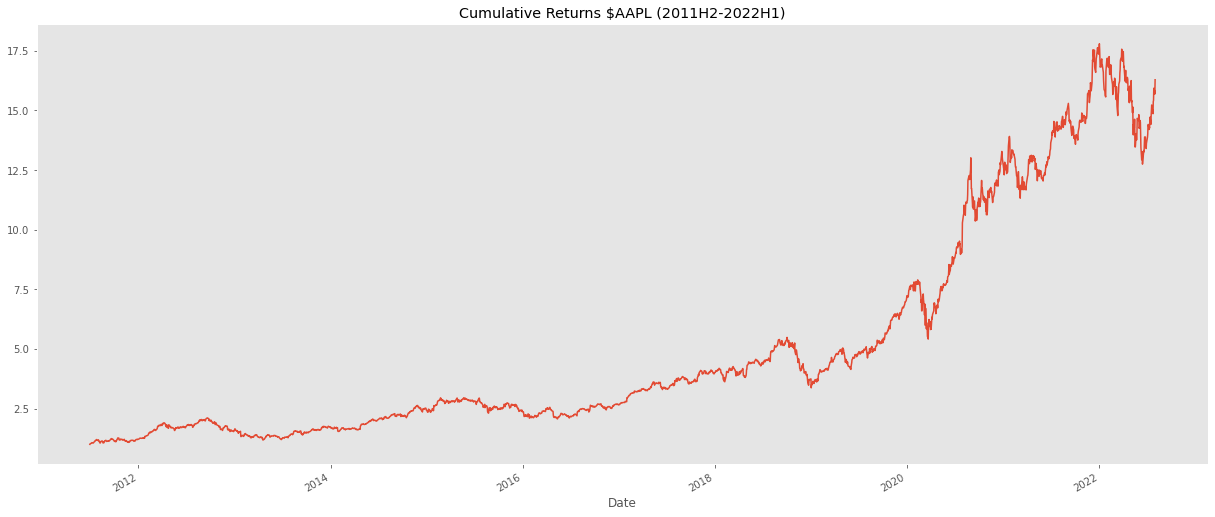

In [5]:
plt.style.use("ggplot")

aapl = daily_rets["AAPL"]
(1+aapl).cumprod().plot(figsize=(21,9), title="Cumulative Returns $AAPL (2011H2-2022H1)")
plt.grid();

### 3.1.1 Sharpe Ratio Implementation and Rolling Window Calculation

In [6]:
def sharpe_ratio(y):
    """
    Classical Sharpe Ratio with zero risk-free rate as reference for excess returns

    inputs:
    """
    return np.sqrt(252) * (y.mean() / y.std()) # Annualized ratio

# 1Y Fix Calendar Window. 1Y Business Window are not supported (size-variable)
aapl_sharpe_ratio = daily_rets["AAPL"].rolling(window="365D").apply(sharpe_ratio)

In [7]:
aapl_sharpe_ratio

Date
2011-06-29          NaN
2011-06-30          NaN
2011-07-01    17.402114
2011-07-05    26.160393
2011-07-06    23.988195
                ...    
2022-07-28     0.441493
2022-07-29     0.532523
2022-08-01     0.507017
2022-08-02     0.483748
2022-08-03     0.564543
Name: AAPL, Length: 2796, dtype: float64

#### **A more accurate calculation**

In [8]:
aapl_sharpe_ratio2 = [sharpe_ratio(aapl.loc[trading_date - pd.offsets.DateOffset(months=12):trading_date]) for trading_date in aapl.index]
aapl_sharpe_ratio2 = pd.Series(data = aapl_sharpe_ratio2, index=aapl.index)

#### Comparing both approaches

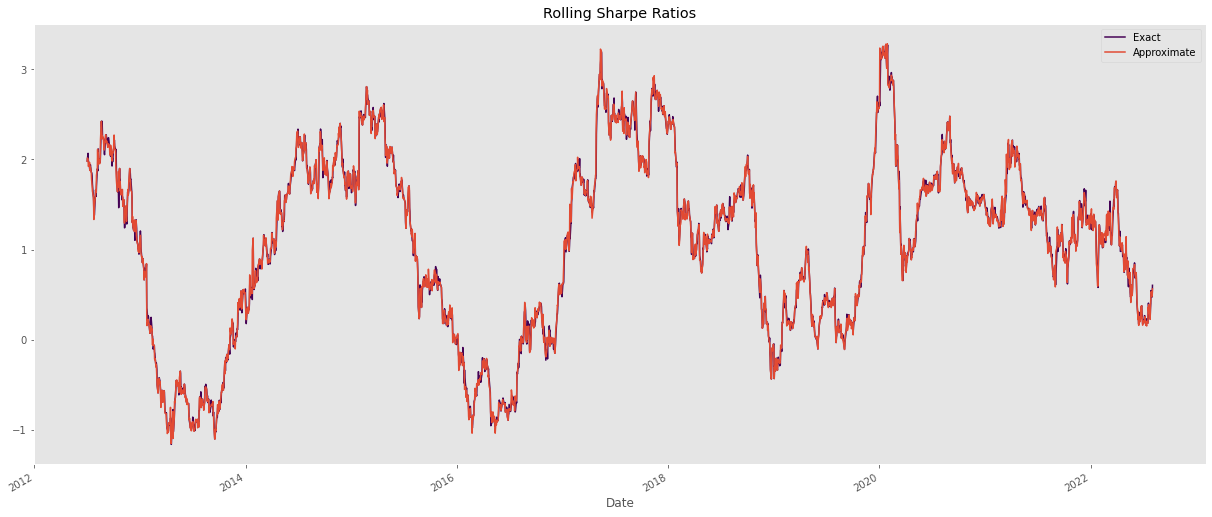

In [9]:
aapl_sharpe_ratio2.rename("Exact")["2012-07-01":].plot(figsize=(21,9), title="Rolling Sharpe Ratios", legend=True, cmap="viridis")
aapl_sharpe_ratio.rename("Approximate")["2012-07-01":].plot(legend=True)
plt.grid();

Let's compare Rolling Sharpe for different portfolios, the single-stock `AAPL` versus equally-weighted `S&P500` (IVV ETF replica)

In [10]:
START_TRAINING_DATE_CUT = "2012-06-29"

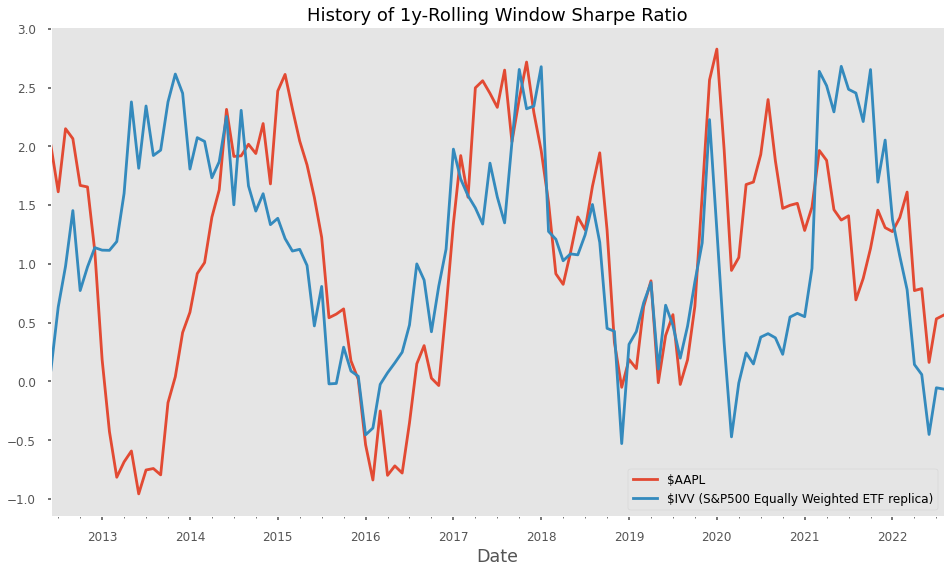

In [11]:
IVV_sharpe_ratio = daily_rets.mean(skipna=True, axis=1).rolling(window="360D").apply(sharpe_ratio)

plt.style.use('seaborn-poster')

aapl_sharpe_ratio.resample("BM").apply(lambda x: x[-1]).rename("$AAPL")[START_TRAINING_DATE_CUT:].plot(
    figsize=(16,9),     
    legend=True,
    fontsize=12    
)
IVV_sharpe_ratio.resample("BM").apply(lambda x: x[-1]).rename("$IVV (S&P500 Equally Weighted ETF replica)")[START_TRAINING_DATE_CUT:].plot(legend=True)
plt.title(label="History of 1y-Rolling Window Sharpe Ratio", fontsize=18)
plt.legend(fontsize=12)
plt.grid();


In [12]:
sharpe_ratio_daily = daily_rets.rolling(window="360D", min_periods=240).apply(sharpe_ratio)

<AxesSubplot:title={'center':'Big Techs Rolling SR Comparison'}, xlabel='Date'>

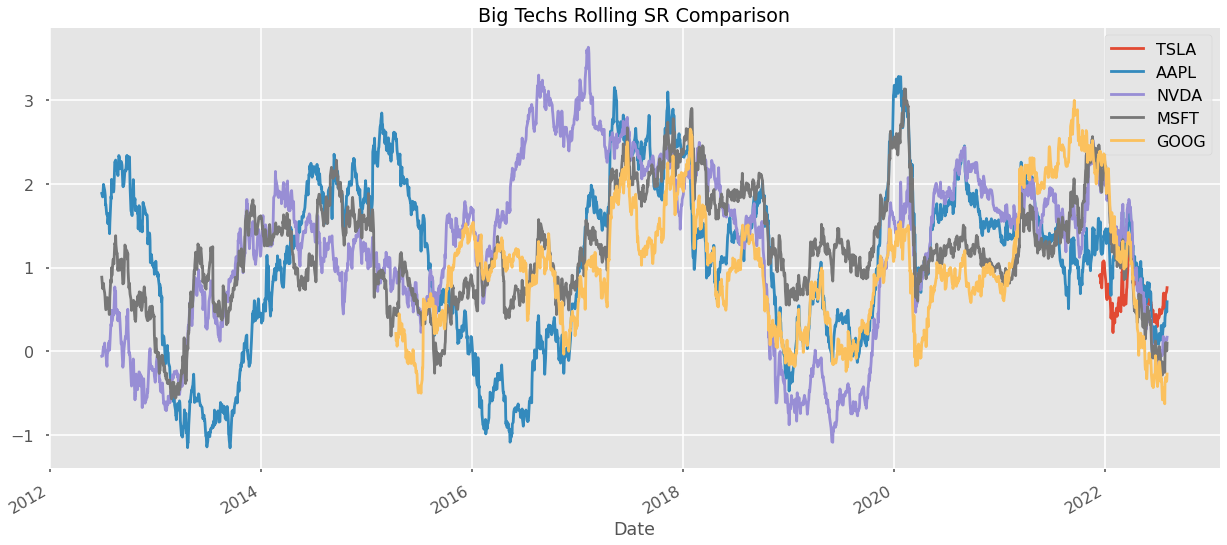

In [13]:
big_techs = ["TSLA", "AAPL", "NVDA", "MSFT", "GOOG"]


sharpe_ratio_daily[big_techs][START_TRAINING_DATE_CUT:].plot(**plot_args)    

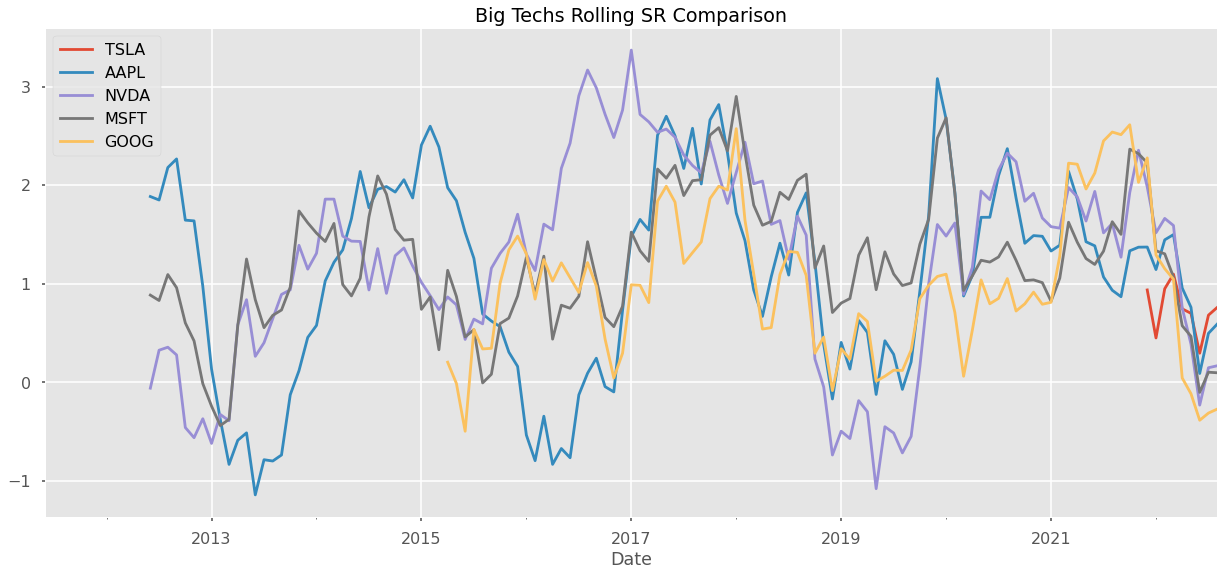

In [14]:
sharpe_ratio_monthly = sharpe_ratio_daily.resample("BM").apply(lambda x: x[-1]) # Simply Pick Up the Business End Of Month Value
sharpe_ratio_monthly[big_techs].plot(**plot_args);

### Appendix A: Implementing an Heuristical (non-ML) Screener based on SR ranks

In [17]:
sharpe_ratio_monthly.loc[START_TRAINING_DATE_CUT,:].sort_values(ascending=False).head(25)

TJX     2.019279
MO      1.976931
KMB     1.970335
SHW     1.966156
ROST    1.931033
AAPL    1.884568
WMT     1.703967
HD      1.680284
DUK     1.652812
PM      1.541682
SRE     1.514499
HSY     1.498546
WEC     1.478330
SO      1.415484
ABT     1.408783
WFM     1.398431
BMY     1.358467
SCG     1.357789
V       1.349151
VZ      1.327350
GPS     1.324705
ISRG    1.318472
NEE     1.316063
CINF    1.303204
MKC     1.277999
Name: 2012-06-29 00:00:00, dtype: float64

In [18]:
sharpe_ratio_monthly.loc[START_TRAINING_DATE_CUT,:].rank().sort_values(ascending=False).head(25)

TJX     459.0
MO      458.0
KMB     457.0
SHW     456.0
ROST    455.0
AAPL    454.0
WMT     453.0
HD      452.0
DUK     451.0
PM      450.0
SRE     449.0
HSY     448.0
WEC     447.0
SO      446.0
ABT     445.0
WFM     444.0
BMY     443.0
SCG     442.0
V       441.0
VZ      440.0
GPS     439.0
ISRG    438.0
NEE     437.0
CINF    436.0
MKC     435.0
Name: 2012-06-29 00:00:00, dtype: float64

1. Ranking Sharpe Ratios each End-Of-Month (EOM):

In [19]:
sharpe_monthly_ranks = sharpe_ratio_monthly.rank(axis=1) # The Higher the Rank the "Better" the Stock
sharpe_monthly_ranks = sharpe_monthly_ranks[START_TRAINING_DATE_CUT:]
sharpe_monthly_ranks.head()

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-29,100.0,9.0,NaN,NaN,454.0,NaN,159.0,NaN,445.0,NaN,...,229.0,55.0,NaN,NaN,359.0,235.0,NaN,123.0,NaN,NaN
2012-07-31,156.0,14.0,NaN,NaN,441.0,NaN,206.0,NaN,446.0,NaN,...,153.0,47.0,NaN,NaN,357.0,132.0,NaN,108.0,NaN,NaN
2012-08-31,126.0,14.0,NaN,NaN,452.0,NaN,76.0,NaN,447.0,NaN,...,132.0,72.0,NaN,NaN,282.0,184.0,NaN,192.0,NaN,NaN
2012-09-28,163.0,45.0,NaN,NaN,439.0,NaN,113.0,NaN,453.0,NaN,...,239.0,80.0,NaN,NaN,349.0,308.0,NaN,234.0,NaN,NaN
2012-10-31,117.0,24.0,NaN,NaN,427.0,NaN,135.0,NaN,428.0,NaN,...,152.0,18.0,NaN,NaN,390.0,359.0,NaN,286.0,NaN,NaN


2. Encoding into CAT1 to CAT20 stock classes

Hard Copying for later use

In [ ]:
sharpe_ratio_rank_encoded = sharpe_monthly_ranks.copy()
sharpe_ratio_rank_encoded

3. Cumulative Returns resample on a Monthly Basis

In [27]:
def net_cumreturn(data, last_row=False):
    df = ((1+data).cumprod(axis=0)-1)
    if last_row:
        return df.iloc[-1]
    return df

monthly_returns = daily_rets.resample("BM").apply(net_cumreturn, last_row=True)[1:-1]

In [28]:
monthly_returns = monthly_returns[START_TRAINING_DATE_CUT:]

In [31]:
monthly_returns.shape

(122, 755)

In [32]:
sharpe_ratio_rank_encoded.shape

(123, 755)

In [33]:
sharpe_ratio_rank_encoded = sharpe_ratio_rank_encoded[:-1]
sharpe_ratio_rank_encoded.tail()

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-31,174.0,NaN,81.0,279.0,422.0,482.0,429.0,186.0,160.0,NaN,...,16.0,NaN,33.0,NaN,253.0,40.0,62.0,285.0,NaN,345.0
2022-04-29,155.0,NaN,196.0,241.0,407.0,466.0,430.0,214.0,211.0,NaN,...,4.0,NaN,18.0,NaN,231.0,31.0,73.0,264.0,NaN,271.0
2022-05-31,191.0,NaN,122.0,272.0,397.0,471.0,463.0,232.0,345.0,NaN,...,4.0,NaN,29.0,NaN,301.0,61.0,22.0,283.0,NaN,240.0
2022-06-30,133.0,NaN,119.0,202.0,315.0,482.0,452.0,226.0,259.0,NaN,...,9.0,NaN,33.0,NaN,304.0,43.0,13.0,323.0,NaN,228.0
2022-07-29,164.0,NaN,132.0,202.0,367.0,456.0,434.0,241.0,154.0,NaN,...,2.0,NaN,42.0,NaN,188.0,46.0,27.0,331.0,NaN,162.0


In [34]:
def scorer(data, bins=20):
    df = pd.cut(x=data, bins=bins, labels=False)
    return 1+df

In [ ]:
sharpe_ratio_rank_encoded = sharpe_ratio_rank_encoded.apply(scorer, axis=1)
sharpe_ratio_rank_encoded

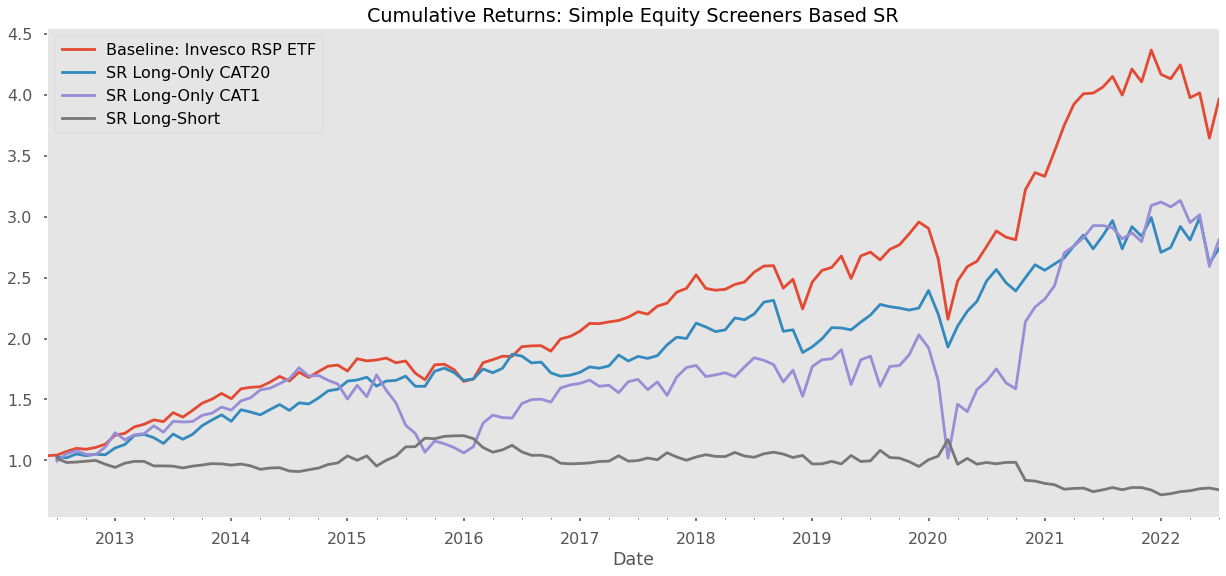

In [38]:
# Heuristic Trading Signals are available to implement during the period-after
mask_best = (sharpe_ratio_rank_encoded.shift(1)==20)
mask_worst = (sharpe_ratio_rank_encoded.shift(1)==1)

# Baseline Strategy
(1+monthly_returns.mean(axis=1,skipna=True)+0.002/12).rename("Baseline: Invesco RSP ETF").cumprod().plot(**plot_args)

# Long Stocks with Best SR Previous Month
(1+monthly_returns[mask_best].mean(axis=1, skipna=True)).rename("SR Long-Only CAT20").cumprod().plot(**plot_args)
(1+monthly_returns[mask_worst].mean(axis=1, skipna=True)).rename("SR Long-Only CAT1").cumprod().plot(**plot_args)

# Long Best and Short "Worst" SR (Problem: when SR<0 usually volatility is also superior -> ranking may be confusing)
(
    (1+0.5*monthly_returns[mask_best].mean(axis=1,skipna=True)-0.5*monthly_returns[mask_worst].mean(axis=1,skipna=True))
        .rename("SR Long-Short")
        .cumprod()
        .plot(**plot_args)
)
plt.title("Cumulative Returns: Simple Equity Screeners Based SR")
plt.grid();


**Conclusion**: The Sharpe Ratio is not a good feature if we want to improve passive replicas. Moreover, with their classical definition, the order induced by this _Performance Measure_ is confusing.

### 3.1.2 Refining Sharpe Ratio Implementation: The Israelsen modified Sharpe Ratio


####  A Preliminar Discussion with $AAPL stock

In [39]:
# rolling().apply() does not work
def israelsen_sharpe_ratio(y):    
    pass

In [42]:
# A separate function is tricky to implement for conditional calculation. With `lambda` fun is straightforward.
aapl_isr_daily = aapl.rolling(window="360D", min_periods=240).apply(
    lambda x: np.sqrt(252)*x.mean()/x.std() if x.mean()>0 else np.sqrt(252)*x.mean()*x.std()
)

aapl_sharpe_ratio = aapl.rolling(window="360D", min_periods=240).apply(sharpe_ratio)

_**Green Line**_: Israelsen Modified (SR) Sharpe Ratio. _**Orange**_: Classical SR

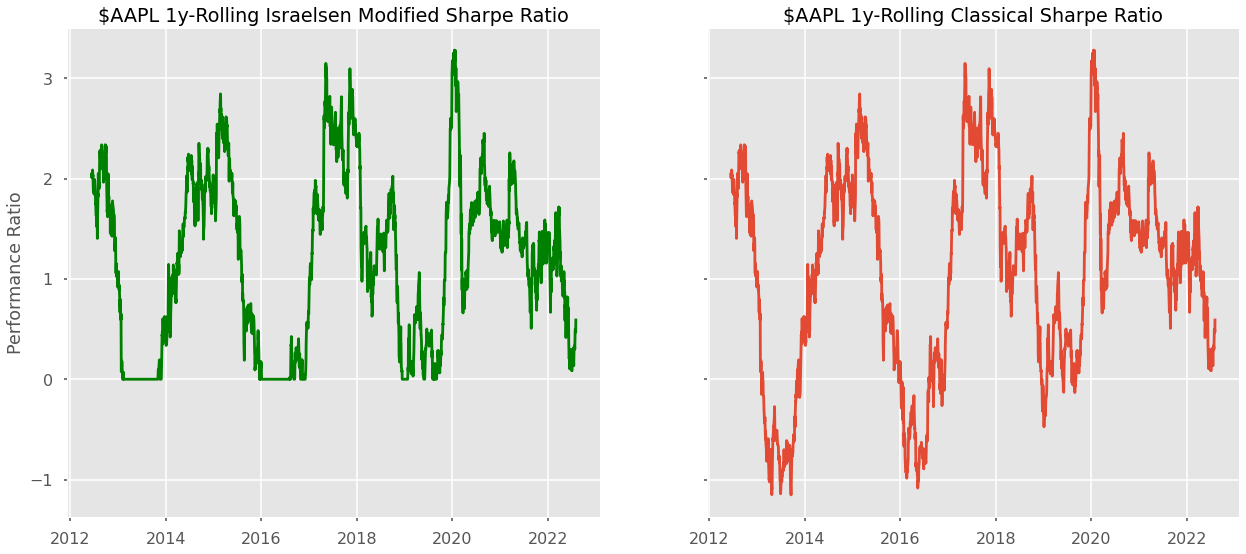

In [43]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(21,9))
ax1.plot(aapl_isr_daily, color="green")
ax2.plot(aapl_sharpe_ratio)
## Posprocessing Multiple Plot
# ax1
ax1.set_title("$AAPL 1y-Rolling Israelsen Modified Sharpe Ratio")
ax1.set_ylabel(ylabel="Performance Ratio")
# ax2
ax2.set_title("$AAPL 1y-Rolling Classical Sharpe Ratio");



####  Reworking all: Cross-Sectional Evidences

In [44]:
isr_sharpe_ratio_daily = daily_rets.rolling(window="360D", min_periods=240).apply(
    lambda x: np.sqrt(252)*x.mean()/x.std() if x.mean()>0 else np.sqrt(252)*x.mean()*x.std()
)

In [45]:
isr_sharpe_ratio_monthly = isr_sharpe_ratio_daily.resample("BM").apply(lambda x: x[-1])
isr_sharpe_ratio_monthly[START_TRAINING_DATE_CUT:].head(5)

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-29,-0.000297,-0.000904,NaN,NaN,1.884568,NaN,-0.000020,NaN,1.408783,NaN,...,0.113627,-0.000300,NaN,NaN,0.685963,0.157201,NaN,-0.000188,NaN,NaN
2012-07-31,0.346394,-0.000541,NaN,NaN,1.849398,NaN,0.493666,NaN,1.986451,NaN,...,0.342355,-0.000176,NaN,NaN,1.107412,0.246050,NaN,0.137914,NaN,NaN
2012-08-31,0.440254,-0.000366,NaN,NaN,2.178672,NaN,0.103325,NaN,1.993481,NaN,...,0.458453,0.083827,NaN,NaN,0.998320,0.621773,NaN,0.656222,NaN,NaN
2012-09-28,0.771920,0.135888,NaN,NaN,2.265817,NaN,0.586095,NaN,2.565410,NaN,...,1.093502,0.379183,NaN,NaN,1.499814,1.346553,NaN,1.078566,NaN,NaN
2012-10-31,0.108293,-0.000240,NaN,NaN,1.644907,NaN,0.200270,NaN,1.669231,NaN,...,0.271570,-0.000236,NaN,NaN,1.344056,1.159166,NaN,0.870904,NaN,NaN


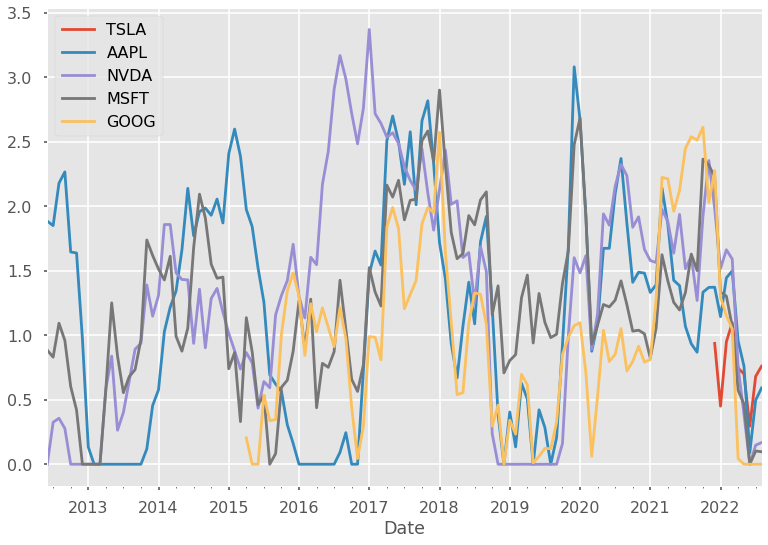

In [46]:
isr_sharpe_ratio_monthly=isr_sharpe_ratio_monthly[START_TRAINING_DATE_CUT:]
isr_sharpe_ratio_monthly[big_techs].plot();

Let's pack features we've constructed (for further exports)

In [422]:
features_dict = {"sharpe": (sharpe_ratio_daily, sharpe_ratio_monthly),
                 "israelsen": (isr_sharpe_ratio_daily, isr_sharpe_ratio_monthly)
}

Some additional checks

####  Heuristics: Equity Screening with Israelsen modified Sharpe Ratio

In [49]:
isr_sharpe_ratio_monthly.iloc[0].sort_values(ascending=False).head(10)

TJX     2.019279
MO      1.976931
KMB     1.970335
SHW     1.966156
ROST    1.931033
AAPL    1.884568
WMT     1.703967
HD      1.680284
DUK     1.652812
PM      1.541682
Name: 2012-06-29 00:00:00, dtype: float64

In [51]:
isr_sharpe_ratio_rank_encoded = isr_sharpe_ratio_monthly.rank(axis=1).apply(scorer, axis=1)
isr_sharpe_ratio_rank_encoded.head()

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-29,3.0,1.0,NaN,NaN,20.0,NaN,8.0,NaN,20.0,NaN,...,10.0,3.0,NaN,NaN,16.0,11.0,NaN,5.0,NaN,NaN
2012-07-31,7.0,1.0,NaN,NaN,20.0,NaN,9.0,NaN,20.0,NaN,...,7.0,3.0,NaN,NaN,16.0,6.0,NaN,5.0,NaN,NaN
2012-08-31,6.0,1.0,NaN,NaN,20.0,NaN,4.0,NaN,20.0,NaN,...,6.0,4.0,NaN,NaN,13.0,8.0,NaN,9.0,NaN,NaN
2012-09-28,8.0,2.0,NaN,NaN,20.0,NaN,5.0,NaN,20.0,NaN,...,11.0,4.0,NaN,NaN,16.0,14.0,NaN,11.0,NaN,NaN
2012-10-31,6.0,2.0,NaN,NaN,19.0,NaN,6.0,NaN,19.0,NaN,...,7.0,2.0,NaN,NaN,17.0,16.0,NaN,13.0,NaN,NaN


In [56]:
isr_sharpe_ratio_rank_encoded.iloc[0].value_counts().sort_index()

1.0     23
2.0     23
3.0     23
4.0     23
5.0     23
6.0     23
7.0     23
8.0     23
9.0     23
10.0    23
11.0    22
12.0    23
13.0    23
14.0    23
15.0    23
16.0    23
17.0    23
18.0    23
19.0    23
20.0    23
Name: 2012-06-29 00:00:00, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


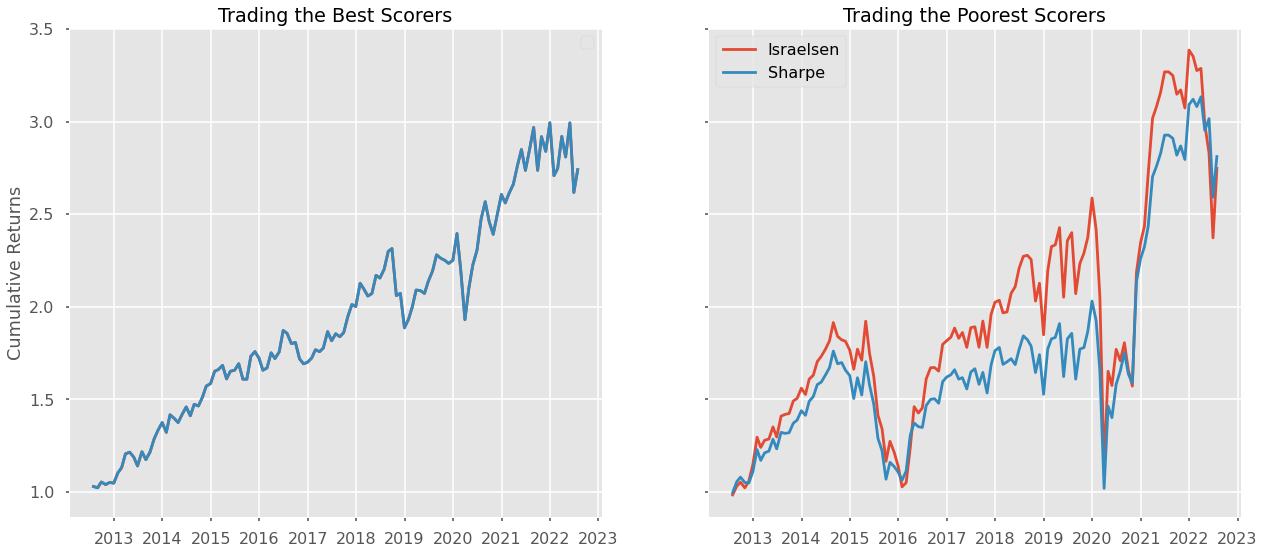

In [88]:
# Heuristic Trading Signals are available to implement during the period-after
isr_mask_best, mask_best = (isr_sharpe_ratio_rank_encoded.shift(1)==20, sharpe_ratio_rank_encoded.shift(1)==20)
isr_mask_worst, mask_worst = (isr_sharpe_ratio_rank_encoded.shift(1)==1, sharpe_ratio_rank_encoded.shift(1)==1)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(21,9), sharey=True)

israelsen_algo_best = (1+monthly_returns[isr_mask_best].mean(axis=1, skipna=True)).rename("Israelsen CAT20 SR Long-Only").cumprod()
ax1.plot(israelsen_algo_best)
sharpe_algo_best = (1+monthly_returns[mask_best].mean(axis=1, skipna=True)).rename("Sharpe CAT20 Long-Only").cumprod()
ax1.plot(sharpe_algo_best)
ax1.set_title("Trading the Best Scorers")
ax1.set_ylabel("Cumulative Returns")
ax1.grid(visible=True, axis="both")
ax1.legend()

israelsen_algo_worst = (1+monthly_returns[isr_mask_worst].mean(axis=1, skipna=True)).rename("Israelsen CAT1 SR Long-Only").cumprod()
line_isr,= ax2.plot(israelsen_algo_worst)
sharpe_algo_worst = (1+monthly_returns[mask_worst].mean(axis=1, skipna=True)).rename("Sharpe CAT1 Long-Only").cumprod()
line_sharpe, = ax2.plot(sharpe_algo_worst)
ax2.set_title("Trading the Poorest Scorers")
ax2.grid(visible=True, axis="both")
ax2.legend(handles = [line_isr, line_sharpe], labels=["Israelsen", "Sharpe"])


**Conclusions**: Israelsen trick becomes relevant for poorest performers (characterized by high volatility/high downturns)

In [463]:
import pickle

with open("data/config/20220814_sharpe_ratio_data.pkl","wb+") as f:
    pickle.dump(features_dict, f)

In [81]:
## Compiling Realized Financial Relevant Stats:
# Top Performers
cat20_realized_vol = monthly_returns[(isr_sharpe_ratio_rank_encoded.shift(1)==20)].mean(axis=1, skipna=True).std()*np.sqrt(12)*100
cat20_realized_mean = monthly_returns[(isr_sharpe_ratio_rank_encoded.shift(1)==20)].mean(axis=1, skipna=True).mean()*12*100
# Poorest Performers
cat1_realized_vol = monthly_returns[(isr_sharpe_ratio_rank_encoded.shift(1)==1)].mean(axis=1, skipna=True).std()*np.sqrt(12)*100
cat1_realized_mean = monthly_returns[(isr_sharpe_ratio_rank_encoded.shift(1)==1)].mean(axis=1, skipna=True).mean()*12*100

# Low Vol Strat
print("Annualized Vol for CAT20 Portfolio: {0:5.2f}%".format(cat20_realized_vol))
# High Vol Strat
print("Annualized Vol for CAT1 Portfolio: {0:5.2f}%".format(cat1_realized_vol))

## Performance Metrics
print()
print("Sharpe Ratio for CAT20 Portfolio: {0:5.2f}%".format(cat20_realized_mean/cat20_realized_vol))
# High Vol Strat
print("Sharpe Ratio for CAT1 Portfolio: {0:5.2f}%".format(cat1_realized_mean/cat1_realized_vol))

Annualized Vol for CAT20 Portfolio: 14.58%
Annualized Vol for CAT1 Portfolio: 34.06%

Sharpe Ratio for CAT20 Portfolio:  0.76%
Sharpe Ratio for CAT1 Portfolio:  0.47%


### Appendix B: Sensibility Analysis


#### B.1 Portfolio Size

In [ ]:
sharpe_ratio_monthly = sharpe_ratio_monthly[START_TRAINING_DATE_CUT:]
sharpe_ratio_monthly

In [92]:
sharpe_ratio_monthly = sharpe_ratio_monthly[:"2022-07-29"]

In [94]:
sharpe_ratio_monthly.rank(axis=1).apply(scorer, bins=20, axis=1)


,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-29,5.0,1.0,NaN,NaN,20.0,NaN,7.0,NaN,20.0,NaN,...,10.0,3.0,NaN,NaN,16.0,11.0,NaN,6.0,NaN,NaN
2012-07-31,7.0,1.0,NaN,NaN,20.0,NaN,9.0,NaN,20.0,NaN,...,7.0,3.0,NaN,NaN,16.0,6.0,NaN,5.0,NaN,NaN
2012-08-31,6.0,1.0,NaN,NaN,20.0,NaN,4.0,NaN,20.0,NaN,...,6.0,4.0,NaN,NaN,13.0,8.0,NaN,9.0,NaN,NaN
2012-09-28,8.0,2.0,NaN,NaN,20.0,NaN,5.0,NaN,20.0,NaN,...,11.0,4.0,NaN,NaN,16.0,14.0,NaN,11.0,NaN,NaN
2012-10-31,6.0,1.0,NaN,NaN,19.0,NaN,6.0,NaN,19.0,NaN,...,7.0,1.0,NaN,NaN,17.0,16.0,NaN,13.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-31,8.0,NaN,4.0,12.0,18.0,20.0,18.0,8.0,7.0,NaN,...,1.0,NaN,2.0,NaN,11.0,2.0,3.0,12.0,NaN,15.0
2022-04-29,7.0,NaN,9.0,10.0,17.0,20.0,18.0,9.0,9.0,NaN,...,1.0,NaN,1.0,NaN,10.0,2.0,3.0,11.0,NaN,12.0
2022-05-31,8.0,NaN,6.0,12.0,17.0,20.0,20.0,10.0,15.0,NaN,...,1.0,NaN,2.0,NaN,13.0,3.0,1.0,12.0,NaN,10.0


Text(0, 0.5, 'Gross Cumulative Returns')

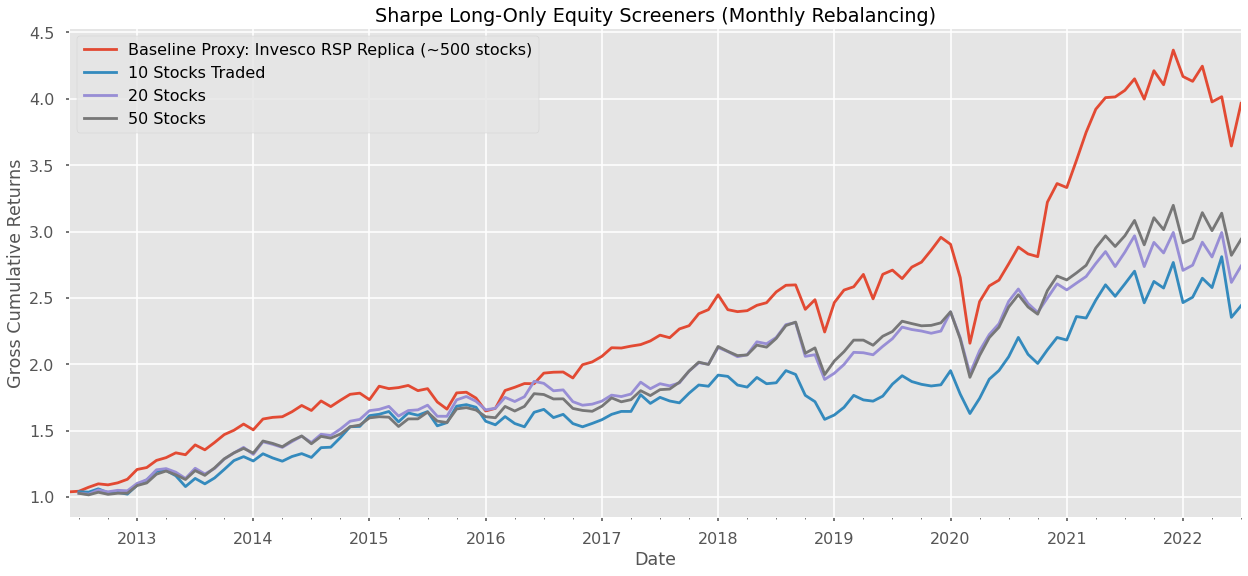

In [98]:
# Baseline Strategy
(1+monthly_returns[START_TRAINING_DATE_CUT:].mean(axis=1,skipna=True)+0.002/12).rename("Baseline Proxy: Invesco RSP Replica (~500 stocks)").cumprod().plot(**plot_args)

# Long Stocks with Best SR Previous Month
labels = ["10 Stocks Traded", "20 Stocks", "50 Stocks"]
bins = [50, 20, 10]
for bin, label in zip(bins,labels):
    mask = (sharpe_ratio_monthly.rank(axis=1).apply(scorer, bins=bin, axis=1).shift(1)==bin)
    (1+monthly_returns[mask].mean(axis=1, skipna=True)).rename(label).cumprod().plot(**plot_args)

plt.title("Sharpe Long-Only Equity Screeners (Monthly Rebalancing)")
plt.ylabel("Gross Cumulative Returns")

i.e. portfolio size matters (complete analysis of performance on the # bins dimension (portfolio size)).

In [ ]:
sharpe_ratio_monthly.rank(axis=1).apply(revelator, bins=bin, axis=1).shift(1).iloc[-1]

#### B.2  Rebalancing (Query) Frequency
1. **Daily**

In [560]:
# Available (Steady and Smooth) 1Y later (1y-Rolling Calculation)
sharpe_ratio_daily = sharpe_ratio_daily[START_TRAINING_DATE_CUT:]
sharpe_ratio_daily.head()

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-29,-0.317014,-1.183331,NaN,NaN,1.884568,NaN,-0.078464,NaN,1.408783,NaN,...,0.113627,-0.577343,NaN,NaN,0.685963,0.157201,NaN,-0.202059,NaN,NaN
2012-07-02,-0.280281,-1.219488,NaN,NaN,1.843379,NaN,-0.064000,NaN,1.411078,NaN,...,0.067279,-0.603802,NaN,NaN,0.727517,0.158991,NaN,-0.208297,NaN,NaN
2012-07-03,-0.245771,-1.141653,NaN,NaN,1.878122,NaN,-0.070828,NaN,1.426115,NaN,...,0.051128,-0.577563,NaN,NaN,0.681182,0.169892,NaN,-0.200435,NaN,NaN
2012-07-05,-0.207605,-1.072562,NaN,NaN,1.992423,NaN,-0.071116,NaN,1.435512,NaN,...,0.062833,-0.507931,NaN,NaN,0.776444,0.218500,NaN,-0.169670,NaN,NaN
2012-07-06,-0.238056,-1.091892,NaN,NaN,1.971463,NaN,-0.138243,NaN,1.423501,NaN,...,0.003557,-0.512105,NaN,NaN,0.804958,0.111152,NaN,-0.178185,NaN,NaN


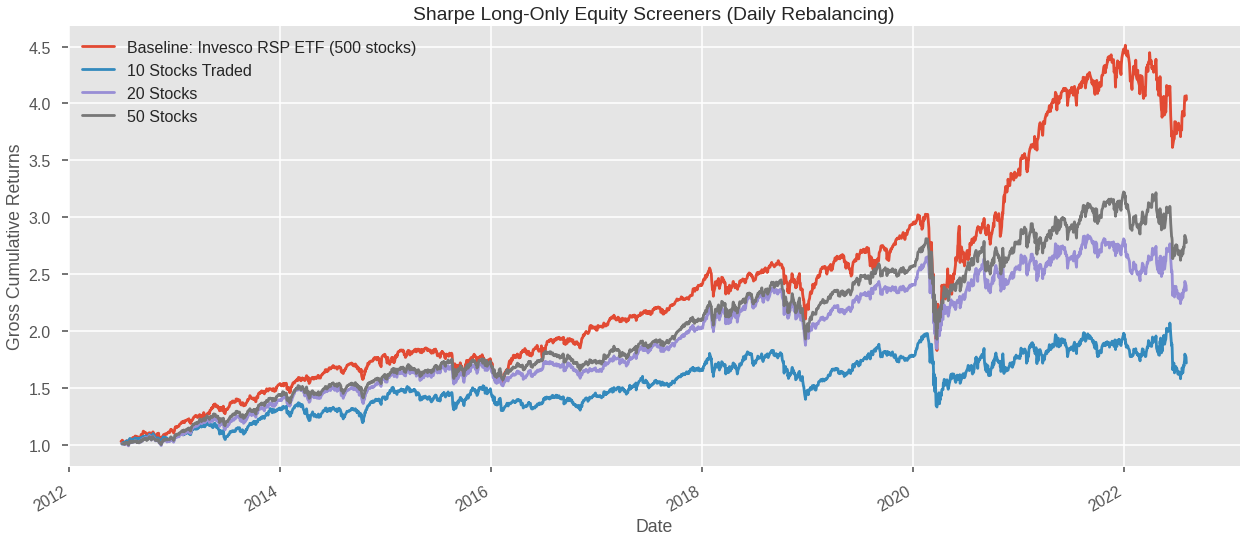

In [573]:
# Baseline Strategy
(1+daily_rets[START_TRAINING_DATE_CUT:].mean(axis=1,skipna=True)+0.002/252).rename("Baseline: Invesco RSP ETF (500 stocks)").cumprod().plot(**plot_args)

# Long Stocks with Best SR Previous Date
labels = ["10 Stocks Traded", "20 Stocks", "50 Stocks"]
bins = [50, 20, 10]
for bin, label in zip(bins,labels):
    mask = (sharpe_ratio_daily.rank(axis=1).apply(revelator, bins=bin, axis=1).shift(1)==bin)
    (1+daily_rets[mask].mean(axis=1, skipna=True)).rename(label).cumprod().plot(**plot_args)

plt.title("Sharpe Long-Only Equity Screeners (Daily Rebalancing)")
plt.ylabel("Gross Cumulative Returns");

2. **Weekly**

Resampling Sharpe Ratio each end-of-week:

In [43]:
sharpe_ratio_weekly = sharpe_ratio_daily.resample("W-FRI").apply(lambda x: x[-1])

In [585]:
daily_rets.iloc[-4:]

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-07-29,0.022805,NaN,-0.003634,0.013558,0.032793,-0.041669,0.002473,0.002772,-0.013773,NaN,...,-0.005227,NaN,0.022783,NaN,-0.001385,-0.003520,0.038287,0.020007,NaN,0.001536
2022-08-01,-0.004996,NaN,0.041575,0.012241,-0.006153,-0.022925,0.000000,-0.003788,0.006248,NaN,...,-0.004978,NaN,-0.009019,NaN,0.001632,-0.005707,0.002069,-0.011366,NaN,-0.015393
2022-08-02,-0.016113,NaN,-0.015406,-0.004949,-0.009287,0.001212,-0.021380,0.005927,-0.008035,NaN,...,-0.011395,NaN,0.045724,NaN,-0.004970,0.039176,-0.097955,-0.015390,NaN,-0.005063
2022-08-03,0.024985,NaN,0.040541,0.001282,0.038248,0.005770,-0.026679,0.026666,0.008929,NaN,...,0.009278,NaN,0.020342,NaN,-0.018996,0.013589,0.009557,0.016196,NaN,0.007437


In [39]:
weekly_returns = daily_rets.resample("W-FRI").apply(net_cumreturn, last_row=True)[1:-3]

<AxesSubplot:xlabel='Date'>

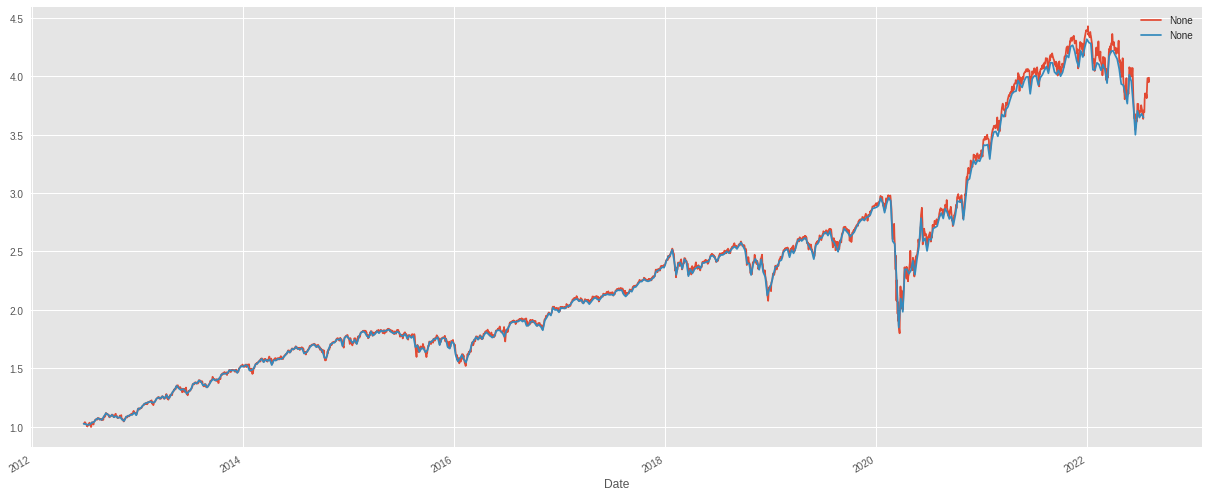

In [40]:
(1+daily_rets.mean(axis=1,skipna=True))[START_TRAINING_DATE_CUT:].cumprod().plot(figsize=(21,9), legend=True)
(1+weekly_returns.mean(axis=1,skipna=True))[START_TRAINING_DATE_CUT:].cumprod().plot(legend=True)

In [14]:
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [44]:
def revelator(data, bins=20): #John, The Revelator    
    df = pd.cut(x=data, bins=bins, labels=False)
    return 1+df

In [56]:
sharpe_ratio_weekly = sharpe_ratio_weekly[START_TRAINING_DATE_CUT:]
sharpe_ratio_weekly

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-29,-0.317014,-1.183331,NaN,NaN,1.884568,NaN,-0.078464,NaN,1.408783,NaN,...,0.113627,-0.577343,NaN,NaN,0.685963,0.157201,NaN,-0.202059,NaN,NaN
2012-07-06,-0.238056,-1.091892,NaN,NaN,1.971463,NaN,-0.138243,NaN,1.423501,NaN,...,0.003557,-0.512105,NaN,NaN,0.804958,0.111152,NaN,-0.178185,NaN,NaN
2012-07-13,-0.243097,-1.132959,NaN,NaN,1.755332,NaN,-0.009923,NaN,1.523111,NaN,...,-0.079896,-0.701135,NaN,NaN,0.794747,0.151176,NaN,-0.117265,NaN,NaN
2012-07-20,-0.117759,-1.183795,NaN,NaN,1.523899,NaN,0.128479,NaN,1.563879,NaN,...,0.007656,-0.803698,NaN,NaN,0.903468,0.222198,NaN,-0.175640,NaN,NaN
2012-07-27,0.196439,-0.929731,NaN,NaN,1.533312,NaN,0.303353,NaN,1.893822,NaN,...,0.242282,-0.452236,NaN,NaN,1.193289,0.257144,NaN,-0.005636,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-08,-0.514248,NaN,-0.366030,-0.199802,0.201371,1.585160,1.178877,-0.172279,-0.156210,NaN,...,-1.605691,NaN,-1.220556,NaN,0.197567,-1.050918,-1.448234,0.229728,NaN,-0.308069
2022-07-15,-0.609675,NaN,-0.348096,-0.117638,0.260230,1.629006,1.083050,-0.192796,-0.189091,NaN,...,-1.666985,NaN,-1.309415,NaN,0.265536,-1.089276,-1.391047,0.272764,NaN,-0.397891
2022-07-22,-0.427034,NaN,-0.518752,-0.151062,0.333086,1.377832,0.902325,-0.069228,-0.207691,NaN,...,-1.678024,NaN,-1.057854,NaN,-0.031863,-1.126773,-1.212023,0.307178,NaN,-0.336749


In [67]:
sharpe_ratio_weekly.rank(axis=1).apply(revelator, bins=bin, axis=1).shift(1)==bin

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-29,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2012-07-06,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2012-07-13,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2012-07-20,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2012-07-27,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-08,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2022-07-15,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2022-07-22,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


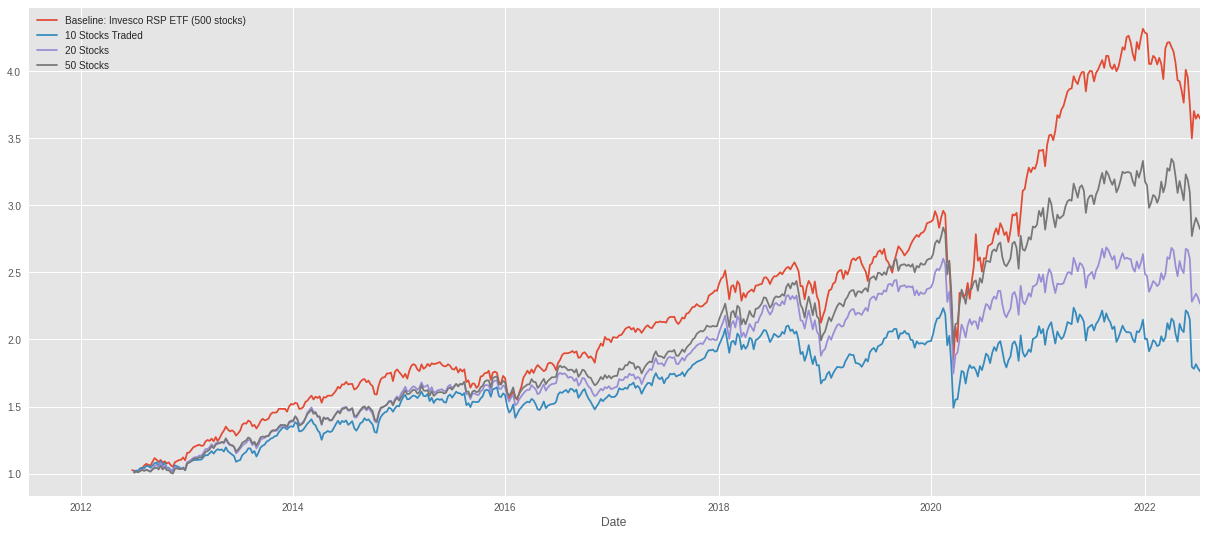

In [69]:
# Baseline Strategy
(1+weekly_returns[START_TRAINING_DATE_CUT:].mean(axis=1,skipna=True)).rename("Baseline: Invesco RSP ETF (500 stocks)").cumprod().plot(**plot_args)

# Long Stocks with Best SR Previous Date
labels = ["10 Stocks Traded", "20 Stocks", "50 Stocks"]
bins = [50, 20, 10]
for bin, label in zip(bins,labels):
    mask = (sharpe_ratio_weekly.rank(axis=1).apply(revelator, bins=bin, axis=1).shift(1)==bin)
    (1+weekly_returns[mask].mean(axis=1, skipna=True)).rename(label).cumprod().plot(**plot_args)

In [132]:
data = {"sharpe": (sharpe_daily, sharpe_weekly, sharpe_monthly),
        "israelsen": (isr_daily, isr_monthly)
}

In [140]:
with open("data/config/20220814_sharpe_ratio_data.pkl","wb") as pkl_file:
    pickle.dump(data, pkl_file)

In [151]:
bin = 10
mk = (sharpe_daily.rank(axis=1).apply(revelator, bins=bin, axis=1).shift(1)==bin)
daily_rets[mk]

,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACE,...,XRAY,XRX,XYL,YHOO,YUM,ZBH,ZBRA,ZION,ZMH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2011-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-28,NaN,NaN,NaN,NaN,NaN,-0.009262,0.003447,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-29,NaN,NaN,NaN,NaN,NaN,-0.041669,0.002473,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Playing with frequency of rebalancing (Resampling)

In [158]:
plot_args = {"figsize": (21,9),
            "title": "The Effect of Frequency of Rebalancing Porfolios",
            "legend": True,
            "ylabel": "Gross Returns"
}

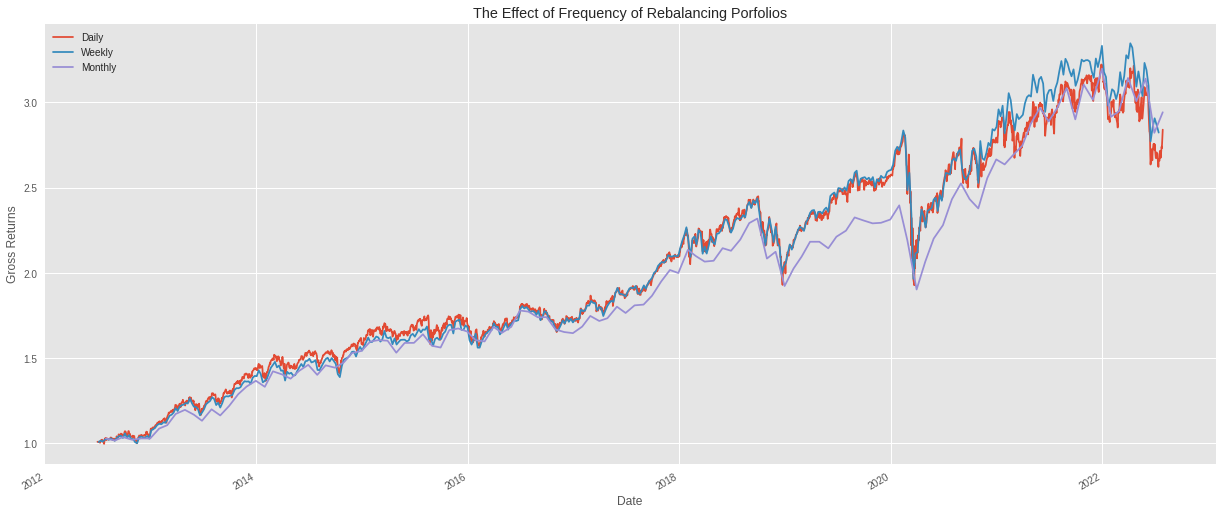

In [159]:
# Long Stocks with Best SR Previous Date
labels = ["Daily", "Weekly", "Monthly"]
bin = 10
freqs = [(daily_rets, sharpe_daily), 
        (weekly_returns, sharpe_weekly), 
        (monthly_returns, sharpe_monthly)
]

for freq, label in zip(freqs,labels):
    mask = (freq[1].rank(axis=1).apply(revelator, bins=bin, axis=1).shift(1)==bin)
    (1+freq[0][mask].mean(axis=1, skipna=True)).rename(label).cumprod().plot(**plot_args)